# Visualize weights of shared encoder to see if one modality dominates the other

In [2]:
MODEL_PATH = '../saved_models/10x_tune_joint_cnn_epoch_00100.pt'

In [3]:
import sys
sys.path.insert(0, '..')
import tcr_embedding as tcr
import scanpy as sc
import json
from matplotlib import rcParams
import torch

path_data = '../data/10x_CD8TC/v5_train_val_test.h5ad'
data_full = sc.read_h5ad(path_data)
data_full = data_full[data_full.obs['set'] != 'test']

high_antigen_count = ['A0201_ELAGIGILTV_MART-1_Cancer_binder',
                        'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
                        'A0201_GLCTLVAML_BMLF1_EBV_binder',
                        'A0301_KLGGALQAK_IE-1_CMV_binder',
                        'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
                        'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
                        'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
                        'B0801_RAKFKQLL_BZLF1_EBV_binder']

data_full.obs['binding_name'][~data_full.obs['binding_name'].isin(high_antigen_count)] = 'no_data'

data_train = data_full[data_full.obs['set'] == 'train']
data_train.obs['binding_name'][~data_train.obs['binding_name'].isin(high_antigen_count)] = 'no_data'
data_val = data_full[data_full.obs['set'] == 'val']
data_val.obs['binding_name'][~data_val.obs['binding_name'].isin(high_antigen_count)] = 'no_data'

data_val.obs['binding_name'].unique()

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


['no_data', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 'B0801_RAKFKQLL_BZLF1_EBV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0201_ELAGIGILTV_MART-1_Cancer_binder']
Categories (9, object): ['no_data', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', ..., 'B0801_RAKFKQLL_BZLF1_EBV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0201_ELAGIGILTV_MART-1_Cancer_binder']

In [4]:
model_file = torch.load(MODEL_PATH)
# params['scRNA_model_hyperparams']['gene_hidden'] = [params['scRNA_model_hyperparams']['gene_hidden']]
# params['shared_hidden'] = [params['shared_hidden']]

In [5]:
params = model_file['params']
print(params)

{'seq_model_arch': 'CNN', 'seq_model_hyperparams': {'num_features_1': 40, 'num_features_2': 75, 'num_features_3': 200, 'dropout': 0.05, 'batch_norm': False, 'embedding_dim': 30, 'encoder': {'kernel_1': 4, 'kernel_23': 4, 'stride_1': 3, 'stride_23': 3, 'num_layers': None, 'activation': 'leakyrelu', 'kernel': [4, 4, 4], 'stride': [3, 3, 3], 'num_features': [40, 75, 200], 'dropout': 0.05, 'batch_norm': False, 'embedding_dim': 30}, 'decoder': {'kernel_1': 3, 'kernel_2': 5, 'stride_1': 3, 'stride_2': 2, 'initial_feature': 150, 'initial_len': 7, 'num_layers': None, 'activation': 'relu', 'kernel': [3, 5], 'stride': [3, 2], 'num_features': [150, 200, 75], 'dropout': 0.05, 'batch_norm': False, 'embedding_dim': 30}, 'num_features': [40, 75, 200], 'max_tcr_length': 47}, 'scRNA_model_arch': 'MLP', 'scRNA_model_hyperparams': {'activation': 'leakyrelu', 'batch_norm': True, 'dropout': 0.05, 'gene_hidden': [1750], 'output_activation': 'relu'}, 'zdim': 180, 'hdim': 300, 'activation': 'leakyrelu', 'drop

In [12]:
trained_model = tcr.models.joint_model.JointModel(
        adatas=[data_full],  # adatas containing gene expression and TCR-seq
        names=['10x'],
        aa_to_id=data_full.uns['aa_to_id'],  # dict {aa_char: id}
        seq_model_arch=params['seq_model_arch'],  # seq model architecture
        seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
        scRNA_model_arch=params['scRNA_model_arch'],
        scRNA_model_hyperparams=params['scRNA_model_hyperparams'],
        zdim=params['zdim'],  # zdim
        hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
        activation=params['activation'],  # activation function of autoencoder hidden layers
        dropout=params['dropout'],
        batch_norm=params['batch_norm'],
        shared_hidden=params['shared_hidden'],  # hidden layers of shared encoder / decoder
        gene_layers=[],  # [] or list of str for layer keys of each dataset
        seq_keys=[]  # [] or list of str for seq keys of each dataset
    )
trained_model.load(MODEL_PATH)

In [13]:
trained_model.model

JointModelTorch(
  (seq_encoder): CNNEncoder(
    (embedding): Embedding(24, 30, padding_idx=0)
    (cnn_blocks): Sequential(
      (0): Sequential(
        (0): Conv1d(30, 40, kernel_size=(4,), stride=(3,), padding=(1,))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Dropout(p=0.05, inplace=False)
      )
      (1): Sequential(
        (0): Conv1d(40, 75, kernel_size=(4,), stride=(3,), padding=(1,))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Dropout(p=0.05, inplace=False)
      )
      (2): Sequential(
        (0): Conv1d(75, 200, kernel_size=(4,), stride=(3,), padding=(1,))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Dropout(p=0.05, inplace=False)
      )
    )
    (output_layer): Linear(in_features=400, out_features=300, bias=True)
  )
  (seq_decoder): CNNDecoder(
    (input_layer): Linear(in_features=600, out_features=1050, bias=True)
    (conv_transpose_blocks): Sequential(
      (0): Sequential(
        (

In [18]:
shared_layer = trained_model.model.shared_encoder.network[0][0]

In [27]:
for param in shared_layer.parameters():
    weights = param.data

In [30]:
weights.shape

torch.Size([100, 600])

In [32]:
scRNA_weights = weights[:, :weights.shape[1]//2]
tcr_weights = weights[:, weights.shape[1]//2:]

In [56]:
scRNA_weights.shape

torch.Size([100, 300])

Text(0.5, 1.0, 'Weights of first joint layer')

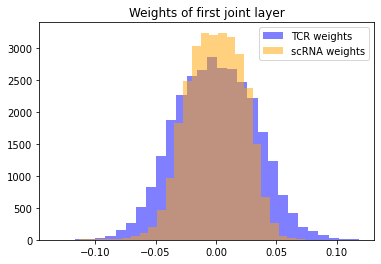

In [59]:
plt.hist(tcr_weights.flatten().numpy(), density=False, bins=30, color='blue', alpha=0.5)
plt.hist(scRNA_weights.flatten().numpy(), density=False, bins=30, color='orange', alpha=0.5)
plt.legend(['TCR weights', 'scRNA weights'])
plt.title('Weights of first joint layer')

In [55]:
tcr_weights.flatten().numpy()

array([-0.05592087, -0.00669516, -0.01247656, ...,  0.03074455,
        0.03786825,  0.05502507], dtype=float32)